<a href="https://colab.research.google.com/github/EbrahimiAmirHosein/Recommender-System/blob/main/GCN/Recommender_Systems_with_Graph_Neural_Networks_in_PyG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install required packages

In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


## Download dataset from Google Drive

In [3]:
'''
Link: https://drive.google.com/file/d/1Woaz_3DC9q7uBBxoiibQf5UsBYSWT611/view?usp=sharing

id = 1Woaz_3DC9q7uBBxoiibQf5UsBYSWT611
'''

!gdown --id 1Woaz_3DC9q7uBBxoiibQf5UsBYSWT611
!unzip ml-100k.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Woaz_3DC9q7uBBxoiibQf5UsBYSWT611
To: /content/ml-100k.zip
100% 4.95M/4.95M [00:00<00:00, 10.7MB/s]
Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/README          
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-10

# Import Libraries

In [4]:
import random
import time

import plotly.express as px
import networkx as next
import numpy as np
import pandas as pd


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim  as optim

import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm

from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading data and Preprocessing

In [6]:
df = pd.read_csv("ml-100k/u.data",sep="\t",names= ['user_id','item_id','rating','timestamp'])
print(len(df))
df.head(5)

100000


,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


# Selecting those that have rating more than 3

In [7]:
df = df[df['rating'] >= 3]
print(f"only {len(df)} out of 100k were selected")

only 82520 out of 100k were selected


# Distribution of ratings

<Axes: ylabel='Frequency'>

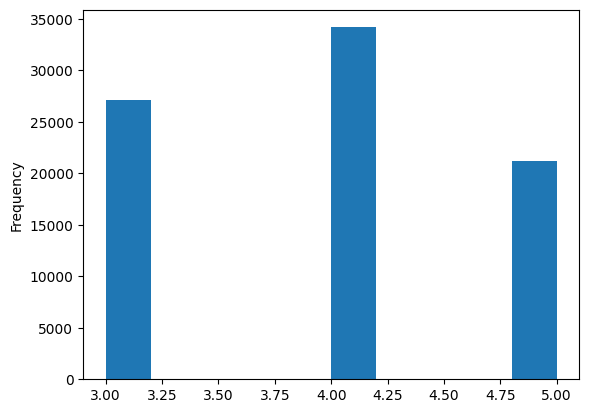

In [8]:
df['rating'].plot.hist()

## Train and Test split

In [9]:
train, test = train_test_split(df.values, test_size = 0.2, random_state = 1234)

df_train = pd.DataFrame(train, columns = df.columns)
df_test = pd.DataFrame(test, columns = df.columns)

print(f" Train size : {len(df_train)}, Test size : {len(df_test)}")

 Train size : 66016, Test size : 16504


Adding another col, by relabeling based on the user and item id. This is becuase after randomly spliting the data, not all of users and items may be present in training set.

In [10]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
df_train['user_id_idx'] = le_user.fit_transform(df_train['user_id'].values)
df_train['item_id_idx'] = le_item.fit_transform(df_train['item_id'].values)

In [11]:
print(f" number of unique elements in user_id : {len(df_train['user_id'].unique())}\n number of unique elements in item_id : {len(df_train['item_id'].unique())}" )

 number of unique elements in user_id : 943
 number of unique elements in item_id : 1547


In [12]:
# We want our test data to have the same values as there are in the training data

unique_user_train = df_train['user_id'].unique()
unique_item_train = df_train['item_id'].unique()

df_test = df_test[
    (df_test['user_id'].isin(unique_user_train)) & (df_test['item_id'].isin(unique_item_train))
]
print(len(df_test))

16473


In [13]:
df_test['user_id_idx'] = le_user.fit_transform(df_test['user_id'].values)
df_test['item_id_idx'] = le_item.fit_transform(df_test['item_id'].values)

<ipython-input-13-81c9a4671419>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['user_id_idx'] = le_user.fit_transform(df_test['user_id'].values)
<ipython-input-13-81c9a4671419>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['item_id_idx'] = le_item.fit_transform(df_test['item_id'].values)


In [14]:
n_users = df_train['user_id_idx'].nunique()
n_items = df_train['item_id_idx'].nunique()

### Minibatch Sampling

We need to add `n_usr` to the sampled positive and negative items, since each node must have a unique id when using PyG.

**Positive items** : Those having a link between users and items

**Negative items** : Those not having a link between users and items


In [15]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device),
        torch.LongTensor(list(pos_items)).to(device) + n_usr,
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(df_train, 16, n_users, n_items)

(tensor([ 30,  97, 131, 163, 240, 355, 454, 455, 468, 515, 560, 620, 671, 838,
         907, 936], device='cuda:0'),
 tensor([1421, 1680, 1599, 1241, 1230, 1255, 1651,  999, 1444, 1298, 1577, 1122,
          992, 1063, 1075,  992], device='cuda:0'),
 tensor([1920, 2275, 1134, 2250, 1755, 1709, 2046, 2352, 1434, 1799, 1563, 1071,
         2108, 1663, 2009, 1018], device='cuda:0'))

In [16]:
'''
PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice,
 once for the edges from the users to the items and vice-versa.

Similar to above, we add n_users to the item tensor to ensure that every node in the graph has a unique identifier.
'''
u_t = torch.LongTensor(df_train.user_id_idx)
i_t = torch.LongTensor(df_train.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)

train_edge_index

tensor([[  12,  913,  431,  ..., 1248, 1872, 1059],
        [1334, 1343, 1698,  ...,  513,  404,  563]], device='cuda:0')

In [17]:
print(f"{train_edge_index[:,-1]} , { train_edge_index[:, 0]}\n {train_edge_index[:, len(train)-1]} , { train_edge_index[:, len(train)]}")

tensor([1059,  563], device='cuda:0') , tensor([  12, 1334], device='cuda:0')
 tensor([ 563, 1059], device='cuda:0') , tensor([1334,   12], device='cuda:0')





### LightGCN Convolutional Layer

The LightGCN architecture rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$


*Aggregation*: $\sum\limits_{i \in N_u}$

*Message*: $\frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$

In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.

In [24]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

### Recommender System GNN

We will be using the following class, `RecSysGNN` in order to stack the LightGCN convolutional layers. Some considerations that can be made for tweaking the models are the number of layers of your model and dropout. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are `n`-hops away in a model that uses `n` layers. Dropout can be tweaked to try out different regularization schemes.


In [18]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, #'LightGCN'
      dropout=0.1
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'LightGCN'), \
        'Model must be LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'LightGCN':
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))


    self.init_parameters()


  def init_parameters(self):
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = torch.mean(torch.stack(embs, dim=0), dim=0)


    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

## Loss function and metrics

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.


**BPR loss for each minibatch**:

$$\frac{1}{\left|U_{\text {mini }}\right|} \sum_{u^* \in U_{\text {mini }}}-\log \left(\sigma\left(f_\theta\left(u^*, v_{\text {pos }}\right)-f_\theta\left(u^*, v_{n e g}\right)\right)\right)$$

In [19]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [20]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id_idx'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(df_train['user_id_idx'].values),
    torch.LongTensor(df_train['item_id_idx'].values)
  ))
  v = torch.ones((len(df_train)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id_idx',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id_idx, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id_idx']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

In [21]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [27]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, df_train, df_test, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

In [25]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2490, 64])]


In [28]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, df_train)

  0%|          | 0/50 [00:00<?, ?it/s]

<ipython-input-20-177fe603a35a>:12: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\


In [29]:
epoch_list = [(i+1) for i in range(EPOCHS)]

In [37]:
import plotly.graph_objects as go

# Create traces
trace1 = go.Scatter(x=epoch_list, y=light_loss, mode='lines', name='Total Training Loss')
trace2 = go.Scatter(x=epoch_list, y=light_bpr, mode='lines', name='BPR Training Loss')
trace3 = go.Scatter(x=epoch_list, y=light_reg, mode='lines', name='Reg Training Loss')

# Create layout
layout = go.Layout(title='Training Loss',
                   xaxis=dict(title='Epoch'),
                   yaxis=dict(title='Loss'))

# Create figure
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)

# Show the figure
fig.show()

In [38]:
# Create traces
trace1 = go.Scatter(x=epoch_list, y=light_recall, mode='lines', name='Recall')
trace2 = go.Scatter(x=epoch_list, y=light_precision, mode='lines', name='Precisions')


# Create layout
layout = go.Layout(
                   xaxis=dict(title='Epoch'),
                   yaxis=dict(title='Loss'))

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the figure
fig.show()